# Метод Галеркина в линейной модели

Пример: уравнение u''(x) = - x , x э [0,1], u(0)=u(1)=0

In [ ]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

### 1. Определяем символы

In [ ]:
x = sp.Symbol('x')
c1,c2 = sp.symbols('c1,c2')

##2. Задаем базисные функции


In [ ]:
phi1 = sp.sin(sp.pi * x)
phi2 = sp.sin(2 * sp.pi * x)
phi = [phi1,phi2]

#### Аппроксиммированное решение:

In [ ]:
u_hat = c1 * phi1 + c2 * phi2

#### Правая часть уравнения

In [ ]:

f = - (sp.pi**2) * sp.sin(sp.pi * x)


### 3. Находим невязку R(x) = u''(x) + u(x) - f(x)

In [ ]:
R = sp.diff(u_hat,x,2) + u_hat - f

4. Условие Галеркина: ∫ R(x)*ф_i(x) dx =0 для каждого i

In [ ]:
A = sp.Matrix([
    [sp.integrate(phi[i] * sp.diff(phi[j], x, 2), (x, 0, 1))
     for j in range(2)] for i in range(2)]
)
b = sp.Matrix([sp.integrate(f * phi[i], (x, 0, 1)) for i in range(2)])



5. Решаем систему для коэффииентов c1,c2

In [ ]:
solution = A.LUsolve(b)
c1_val, c2_val = [sp.N(v) for v in solution]

### 6. Визуализация

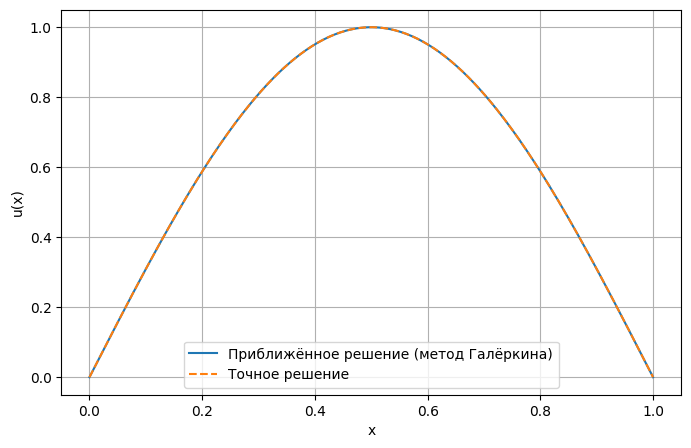

In [ ]:
u_hat_simplified = u_hat.subs({c1: c1_val, c2: c2_val})
u_func = sp.lambdify(x, u_hat_simplified, 'numpy')

x_vals =np.linspace(0,1,300)
u_vals =u_func(x_vals)
u_exact = sp.sin(sp.pi * x)
u_exact_func = sp.lambdify(x, u_exact, 'numpy')
u_exact_vals = u_exact_func(x_vals)

plt.figure(figsize=(8,5))
plt.plot(x_vals, u_vals, label='Приближённое решение (метод Галёркина)')
plt.plot(x_vals, u_exact_vals, '--', label='Точное решение')
plt.xlabel("x")
plt.ylabel("u(x)")
plt.grid(True)
plt.legend()
plt.show()

# Метод Галеркина на нейросейти

## Задача

-u''(x) = f(x) на (0,1),  u(0) = u(1) =0

Метод Галеркина:
INT(0|1) (u'(x)v'(x)) dx = INT(0|1) f(X)v_h(x) dx

u_thet(x) = x(1-x) N(x)

## Реализация

In [ ]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

 ### задаем пи для удобвства

In [ ]:
pi = math.pi

  f(x) = π^2 sin(πx).
    x: [M,1] тензор точек.
    Возвращает тензор [M,1].

In [ ]:
def f_rhs(x: torch.Tensor) -> torch.Tensor:
    return (pi**2) * torch.sin(pi * x)

Точное решение: u(x) = sin(πx).

In [ ]:
def u_exact(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x)

### Двухслойная нейросеть: вход->скрытый->выход

In [ ]:
class TwoLayerNet(nn.Module):
  def __init__(self, hidden=32) -> None:
      super().__init__()
      self.fc1 = nn.Linear(1,hidden)
      self.fc2 = nn.Linear(hidden,1)
      self.act = torch.tanh
  def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.act(self.fc1(x))
      return self.fc2(x)


In [ ]:
def u_trial(x: torch.Tensor, net: nn.Module) -> torch.Tensor:
  """
    u_θ(x) = x(1-x)·N_θ(x).
    Множитель x(1-x) зануляет функцию в 0 и 1 => u(0)=u(1)=0.
    """
  return x* (1.0 -x) * net(x)

def gauss_legendre_2_on_subintervals(n_sub=200):
    """
    2-точечная квадратура Гаусса на каждом из n_sub равных подотрезков.
      xq: [2*n_sub,1] точки
      wq: [2*n_sub,1] веса (с учётом длины подотрезка)
    """
    xi = torch.tensor([ -1.0/math.sqrt(3.0), 1.0/math.sqrt(3.0) ]).view(-1,1)
    wi =torch.tensor([1.0, 1.0]).view(-1,1)

    xs= []; ws=[]
    for k in range(n_sub):
      a = k / n_sub
      b = (k+1) / n_sub
      h = b - a
      # Аффинное отображение [-1,1] → [a,b]
      xk = 0.5*(a+b) + 0.5*h*xi     # [2,1]
      wk = 0.5*h * wi               # [2,1]
      xs.append(xk); ws.append(wk)

    xq = torch.cat(xs, dim=0)
    wq = torch.cat(ws, dim=0)
    return xq, wq


### Устройство/модель/оптимизатор

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = TwoLayerNet(hidden=32).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

### Квадратурные точки: требуем градиент по x (для u')

In [ ]:
xq, wq = gauss_legendre_2_on_subintervals(n_sub=200)
xq = xq.to(device).float().requires_grad_(True)  # require_grad для автодиффа по x
wq = wq.to(device).float()

### Функционал энергии J(u_θ)

$$
J(u_\theta) =
\frac{1}{2} \sum_{i=1}^{N_q} w_i \, \big|u_\theta'(x_i)\big|^2
\;-\;
\sum_{i=1}^{N_q} w_i \, f(x_i)\,u_\theta(x_i)
$$





In [ ]:
def energy_functional() -> torch.Tensor:
    """
    J(u) = 1/2 ∑ w_i |u'(x_i)|^2 - ∑ w_i f(x_i) u(x_i)
    Численное интегрирование по квадратурным точкам (xq, wq).
    """
    # u(x_i)
    u = u_trial(xq, net)
    # u'(x_i) через автодиф по входу xq
    du_dx = torch.autograd.grad(
        outputs=u,
        inputs=xq,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]    # [Q,1]
    # Первая часть: 1/2 ∫ |u'|^2 ≈ 1/2 * Σ w_i * |u'(x_i)|^2
    grad_term = 0.5 * torch.sum((du_dx**2) * wq)
    # Вторая часть: -∫ f u ≈ - Σ w_i f(x_i) u(x_i)
    load_term = torch.sum(f_rhs(xq) * u * wq)
    J = grad_term - load_term
    return J



### Обучение: минимизация J(u_θ)

In [ ]:
max_epochs = 5000
for epoch in range(max_epochs):
  optimizer.zero_grad()
  J = energy_functional()
  J.backward()
  optimizer.step()

  if (epoch+1) % 500 == 0:
    print(f'Epoch {epoch+1}/{max_epochs}, Loss: {J.item()}')

Epoch 500/5000, Loss: -2.4439737796783447
Epoch 1000/5000, Loss: -2.447887659072876
Epoch 1500/5000, Loss: -2.451641321182251
Epoch 2000/5000, Loss: -2.4568467140197754
Epoch 2500/5000, Loss: -2.4623494148254395
Epoch 3000/5000, Loss: -2.465749502182007
Epoch 3500/5000, Loss: -2.466758966445923
Epoch 4000/5000, Loss: -2.4670250415802
Epoch 4500/5000, Loss: -2.467162609100342
Epoch 5000/5000, Loss: -2.4672303199768066


### Оценка точности на равномерной сетке

In [ ]:
with torch.no_grad():
 x_test = torch.linspace(0, 1, 401, device=device).view(-1,1)
 u_pred = u_trial(x_test,net)
 u_true = u_exact(x_test)
 l2_rms = torch.sqrt(torch.mean((u_pred - u_true)**2))
print(f"\nошибка (по узлам): {l2_rms.item():.6e}")


ошибка (по узлам): 1.216584e-03


### Визуализация

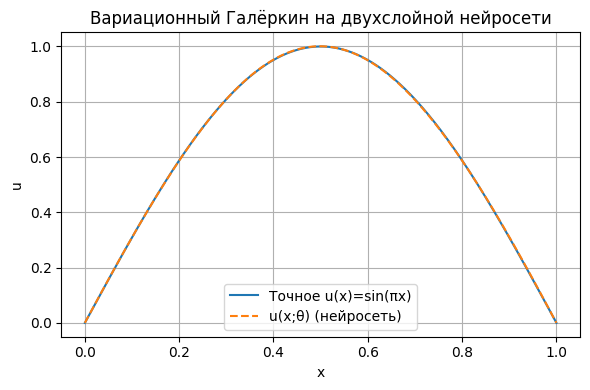

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(x_test.cpu(), u_true.cpu(), label='Точное u(x)=sin(πx)')
plt.plot(x_test.cpu(), u_pred.cpu(), '--', label='u(x;θ) (нейросеть)')
plt.title("Вариационный Галёркин на двухслойной нейросети")
plt.xlabel("x"); plt.ylabel("u")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# Реализация метода Галёркина через ортогональность невязки

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## 1. Определяем правую часть и точное решение

In [ ]:
pi = math.pi

In [ ]:
def f_rhs(x: torch.Tensor) -> torch.Tensor:
    """Правая часть f(x) = π² sin(πx)."""
    return (pi**2) * torch.sin(pi * x)

def u_exact_np(x: np.ndarray) -> np.ndarray:
    """Точное решение u(x) = sin(πx)."""
    return np.sin(pi * x)

## 2. Двухслойная нейросеть

In [ ]:
class TwoLayerNet(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, 1)
        self.act = torch.tanh  # гладкая активация
        # Инициализация весов
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.act(self.fc1(x))
        y = self.fc2(z)
        return y


3. Анзац с граничными условиями

In [ ]:
def u_trial(x: torch.Tensor, net: nn.Module) -> torch.Tensor:
    """u(x;θ) = x(1-x) N_θ(x), автоматически u(0)=u(1)=0"""
    return x * (1.0 - x) * net(x)

## 4. Квадратура Гаусса

In [ ]:
def gauss2_on_subintervals(n_sub=40):
    """Возвращает точки и веса квадратуры Гаусса на [0,1]."""
    xi = np.array([-1.0/np.sqrt(3.0), 1.0/np.sqrt(3.0)]).reshape(-1,1)
    wi = np.array([1.0, 1.0]).reshape(-1,1)
    xs, ws = [], []
    for k in range(n_sub):
        a, b = k/n_sub, (k+1)/n_sub
        h = b - a
        xs.append(0.5*(a+b) + 0.5*h*xi)
        ws.append(0.5*h*wi)
    xq = np.vstack(xs).astype(np.float32)
    wq = np.vstack(ws).astype(np.float32)
    return torch.from_numpy(xq), torch.from_numpy(wq)


## 5. Тестовые функции (полиномы Лежандра)

In [ ]:
def legendre_basis(x: torch.Tensor, m: int) -> torch.Tensor:
  """Вычисляет m первых полиномов Лежандра на [0,1]."""
  t = 2.0*x - 1.0
  Ps = [torch.ones_like(t), t]
  for k in range(1, m-1):
    Pk1 = ((2*k+1)*t*Ps[-1] - k*Ps[-2])/(k+1)
    Ps.append(Pk1)
  return torch.cat(Ps[:m], dim=1)

## 6. Вычисление невязки

In [ ]:
def residual_strong(x: torch.Tensor, net: nn.Module) -> torch.Tensor:
    x = x.detach().clone().requires_grad_(True)
    u = u_trial(x, net)
    du = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    d2u = torch.autograd.grad(du, x, torch.ones_like(du), create_graph=True)[0]
    return -d2u - f_rhs(x)

## 7. Галёркин через ортогональность невязки

In [ ]:
def galerkin_moment_loss(xq: torch.Tensor, wq: torch.Tensor,
                         net: nn.Module, m: int = 8) -> torch.Tensor:
    """ Σ_j (Σ_i w_i * r(x_i) * v_j(x_i))²,
    где v_j — полиномы Лежандра.
    """
    # невязка
    r = residual_strong(xq,net)
    # тестовые функции
    V = legendre_basis(xq,m)
    # моменты
    M = torch.sum((wq * r) * V, dim=0)
    # сумма квадратов моментов
    return torch.sum(M**2)

## 8. Обучение сети (градиентный спуск)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = TwoLayerNet(hidden=32).to(device)
xq, wq = gauss2_on_subintervals(n_sub=40)
xq, wq = xq.to(device), wq.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)
history = []


for epoch in range(1, 251):
  optimizer.zero_grad()
  loss = galerkin_moment_loss(xq,wq,net,m=8)
  loss.backward()
  optimizer.step()
  history.append(loss.item())
  if epoch % 50  == 0:
    print(f"Epoch {epoch:3d} | Moment loss = {loss.item():.6e}")


Epoch  50 | Moment loss = 1.696687e+01
Epoch 100 | Moment loss = 5.458313e+00
Epoch 150 | Moment loss = 3.332552e+00
Epoch 200 | Moment loss = 2.254633e+00
Epoch 250 | Moment loss = 1.798468e+00


## 9. Проверка точности

In [ ]:
with torch.no_grad():
    xt = torch.linspace(0, 1, 201, device=device).view(-1,1)
    ut = u_trial(xt, net)
    ue = torch.sin(pi * xt)
    l2_rms = torch.sqrt(torch.mean((ut - ue)**2)).item()

print(f"\nошибка (по узлам): {l2_rms:.6e}\n")



ошибка (по узлам): 1.378112e-01



## 10. Визуализация

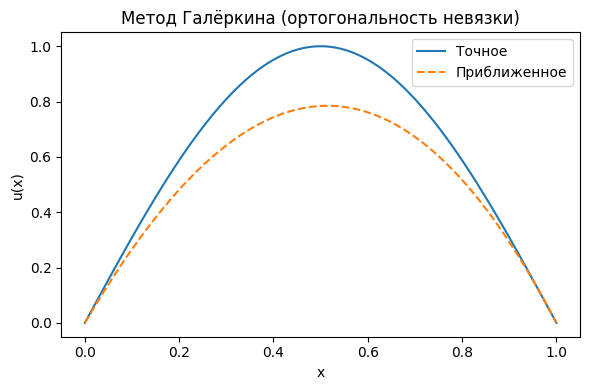

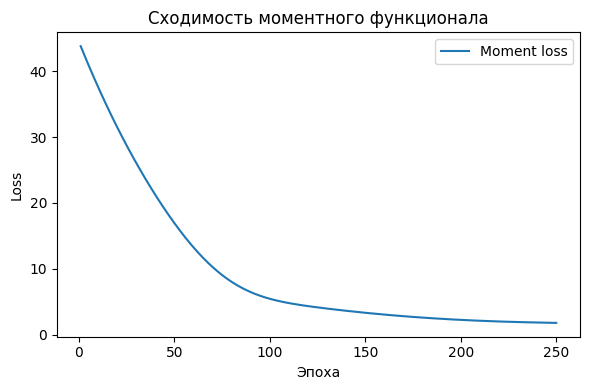

In [ ]:
xt_cpu = xt.cpu().numpy().reshape(-1)
ut_cpu = ut.cpu().numpy().reshape(-1)
ue_cpu = u_exact_np(xt_cpu)

plt.figure(figsize=(6,4))
plt.plot(xt_cpu, ue_cpu, label="Точное")
plt.plot(xt_cpu, ut_cpu, '--', label="Приближенное")
plt.xlabel("x"); plt.ylabel("u(x)")
plt.title("Метод Галёркина (ортогональность невязки)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(history)+1), history, label="Moment loss")
plt.xlabel("Эпоха"); plt.ylabel("Loss")
plt.title("Сходимость моментного функционала")
plt.legend(); plt.tight_layout(); plt.show()
